Prepare dataset for PyTorch by chunking into uniform blocks and replacing NaNs with a low number.

In [3]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import xarray as xr

In [4]:
### User inputs
# len_chunk = 120
# y_lo = 0
# y_hi = 20

len_chunk = 704  # Size as multiples of 2 for diffusers
y_lo = 0
y_hi = 32
ny_in = y_hi - y_lo

n_chan = 5

## Add options to reshape data (e.g., reshape 512x16 data --> 128x64)
# Set ntime_out = len_chunk and ny_in = ny_out if no reshaping is desired
ntime_out = 704
ny_out = 32
assert len_chunk * ny_in == ntime_out * ny_out, "Size mismatch for reshaping!"
reshape_chunks = len_chunk // ntime_out

In [5]:
### Point to data
in_dir = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/simulations/072415/large_campaigns/precursor/postprocessing/wide_gt_and_up')
in_files = list(in_dir.glob('gt*'))
in_files.sort()

out_dir = Path(f'/scratch/orybchuk/wakedynamics/bcs-ldm/simulations/072415/large_campaigns/precursor/postprocessing/for_pytorch_wide_{n_chan}_{ntime_out}_{ny_out}')
out_dir.mkdir(exist_ok=True)

In [6]:
### Calculate min/max values
###   We will eventually replace NaN's with appropriate mins
for icampaign, fcampaign in enumerate(in_files):
    if icampaign % 25 == 0: print(datetime.now(), icampaign, '...')
    
    ds_in = xr.open_dataset(fcampaign)

    # Calculate min/max values needed for dataset scaling
    if icampaign == 0:
        umin_x, umax_x = np.nanmin(ds_in['u_upsampled'].values), np.nanmax(ds_in['u_upsampled'].values)
        umin_y, umax_y = ds_in['u_gt'].values.min(), ds_in['u_gt'].values.max()
        vmin, vmax = ds_in['v_gt'].values.min(), ds_in['v_gt'].values.max()
        wmin, wmax = ds_in['w_gt'].values.min(), ds_in['w_gt'].values.max()
        Tmin, Tmax = ds_in['T_gt'].values.min(), ds_in['T_gt'].values.max()
        TKEmin, TKEmax = ds_in['TKE_gt'].values.min(), ds_in['TKE_gt'].values.max()
    else:
        umin_x, umax_x = min(umin_x, np.nanmin(ds_in['u_upsampled'].values)),  max(umax_x, np.nanmax(ds_in['u_upsampled'].values))
        umin_y, umax_y = min(umin_y, ds_in['u_gt'].values.min()),  max(umax_y, ds_in['u_gt'].values.max())
        vmin, vmax = min(vmin, ds_in['v_gt'].values.min()),  max(vmax, ds_in['v_gt'].values.max())
        wmin, wmax = min(wmin, ds_in['w_gt'].values.min()),  max(wmax, ds_in['w_gt'].values.max())
        Tmin, Tmax = min(Tmin, ds_in['T_gt'].values.min()),  max(Tmax, ds_in['T_gt'].values.max())
        TKEmin, TKEmax = min(TKEmin, ds_in['TKE_gt'].values.min()),  max(TKEmax, ds_in['TKE_gt'].values.max())

umin = min(umin_x, umin_y)
umax = max(umax_x, umax_y)
u_inbetween = 0.5*(umin+umax)

v_inbetween = 0.5*(vmin+vmax)
w_inbetween = 0.5*(wmin+wmax)
T_inbetween = 0.5*(Tmin+Tmax)
TKE_inbetween = 0.5*(TKEmin+TKEmax)

if n_chan == 1:
    nan_replacement_vec = np.array([u_inbetween])
elif n_chan == 5:
    # nan_replacement_vec = np.array([umin, vmin, wmin, Tmin, TKEmin])
    nan_replacement_vec = np.array([u_inbetween,
                                    v_inbetween,
                                    w_inbetween,
                                    T_inbetween,
                                    TKE_inbetween])
    # raise NotImplementedError
print("Gap filling with", nan_replacement_vec)
    
## Save out min/max stats
with open(Path(out_dir, 'stats.txt'), 'w') as f:
    f.write(f'umin: {umin}, umax: {umax}\n')
    f.write(f'vmin: {vmin}, vmax: {vmax}\n')
    f.write(f'wmin: {wmin}, wmax: {wmax}\n')
    f.write(f'Tmin: {Tmin}, Tmax: {Tmax}\n')
    f.write(f'TKEmin: {TKEmin}, TKEmax: {TKEmax}\n')
print(f'umin: {umin}, umax: {umax}')
print(f'vmin: {vmin}, vmax: {vmax}')
print(f'wmin: {wmin}, wmax: {wmax}')
print(f'Tmin: {Tmin}, Tmax: {Tmax}')
print(f'TKEmin: {TKEmin}, TKEmax: {TKEmax}')



2024-06-17 21:22:11.978686 0 ...
2024-06-17 21:22:16.593130 25 ...
2024-06-17 21:22:18.011825 50 ...
2024-06-17 21:22:19.191289 75 ...
2024-06-17 21:22:20.456442 100 ...
2024-06-17 21:22:21.633297 125 ...
2024-06-17 21:22:22.821947 150 ...
2024-06-17 21:22:24.197820 175 ...
2024-06-17 21:22:25.372791 200 ...
2024-06-17 21:22:26.425386 225 ...
2024-06-17 21:22:27.576341 250 ...
2024-06-17 21:22:28.829289 275 ...
2024-06-17 21:22:29.892559 300 ...
2024-06-17 21:22:31.146339 325 ...
Gap filling with [  9.25163471   0.4404083    1.07286723 319.17731398   0.4212696 ]
umin: 3.214014355133783, umax: 15.289255055189235
vmin: -5.653542266524573, vmax: 6.534358873692452
wmin: -4.2332768669062615, wmax: 6.379011318431806
Tmin: 317.8989310331773, Tmax: 320.45569693188133
TKEmin: 8.493264101185955e-05, TKEmax: 0.8424542759164027


In [7]:
### Chunk and replace NaNs
for icampaign, fcampaign in enumerate(in_files):
    if icampaign % 25 == 0: print(datetime.now(), icampaign, '...')
    campaign_id = fcampaign.name[9:13]
    
    ds_in = xr.open_dataset(fcampaign)
    n_time = len(ds_in['time'])

    ## Replace NaN's with a number
    # ds_in = ds_in.fillna(nan_replacement)
    # ds_in['u_upsampled'] = ds_in['u_upsampled'].fillna(umin)
    ds_in['u_upsampled'] = ds_in['u_upsampled'].fillna(u_inbetween)
    
    ## Chunk the Dataset
    window_start = 0
    window_end = len_chunk
    window_iter = 0
    while window_end < n_time:
        # Note: We trim from y=21 --> y=20 because sometimes NNs don't like odd-sized dims
        ds_chunk = ds_in.isel(time=slice(window_start,window_end),y=slice(y_lo,y_hi)).copy()
        
        x_chunk = np.ones((n_chan, len_chunk, y_hi-y_lo)) * nan_replacement_vec[:,None,None]
        y_chunk = np.ones((n_chan, len_chunk, y_hi-y_lo)) * nan_replacement_vec[:,None,None]
        
        x_chunk[0,:,:] = ds_chunk['u_upsampled'].data.copy()
        y_chunk[0,:,:] = ds_chunk['u_gt'].data.copy()
        if n_chan == 5:
            y_chunk[1,:,:] = ds_chunk['v_gt'].data.copy()
            y_chunk[2,:,:] = ds_chunk['w_gt'].data.copy()
            y_chunk[3,:,:] = ds_chunk['T_gt'].data.copy()
            y_chunk[4,:,:] = ds_chunk['TKE_gt'].data.copy()
        
        # Optionally reshape
        if ntime_out != len_chunk:
            # Manually reshape, because np.reshape doesn't give desired order
            x_out = np.zeros((n_chan, ntime_out, ny_out))
            y_out = np.zeros((n_chan, ntime_out, ny_out))
            
            assert ntime_out < len_chunk, "Hardcoded: assuming that we are shortening the time dimension"
            
            ichunk_reshape = 0
            while ichunk_reshape < reshape_chunks:
                x_out[:,:,ichunk_reshape*ny_in:(1+ichunk_reshape)*ny_in] = \
                    x_chunk[:,ichunk_reshape*ntime_out:(1+ichunk_reshape)*ntime_out,:].copy()
                y_out[:,:,ichunk_reshape*ny_in:(1+ichunk_reshape)*ny_in] = \
                    y_chunk[:,ichunk_reshape*ntime_out:(1+ichunk_reshape)*ntime_out,:].copy()
                ichunk_reshape += 1
            
        else:
            x_out = x_chunk
            y_out = y_chunk
        
        np.save(Path(out_dir, f'x_{campaign_id}_{str(window_iter).zfill(2)}.npy'), x_out)
        np.save(Path(out_dir, f'y_{campaign_id}_{str(window_iter).zfill(2)}.npy'), y_out)
        
        window_start = window_end
        window_end += len_chunk
        window_iter += 1

2024-06-17 21:22:32.531257 0 ...
2024-06-17 21:22:33.303320 25 ...
2024-06-17 21:22:34.376417 50 ...
2024-06-17 21:22:35.092821 75 ...
2024-06-17 21:22:36.013895 100 ...
2024-06-17 21:22:36.785283 125 ...
2024-06-17 21:22:37.468649 150 ...
2024-06-17 21:22:38.156264 175 ...
2024-06-17 21:22:38.843547 200 ...
2024-06-17 21:22:39.527419 225 ...
2024-06-17 21:22:40.237870 250 ...
2024-06-17 21:22:40.926037 275 ...
2024-06-17 21:22:41.606757 300 ...
2024-06-17 21:22:42.322050 325 ...


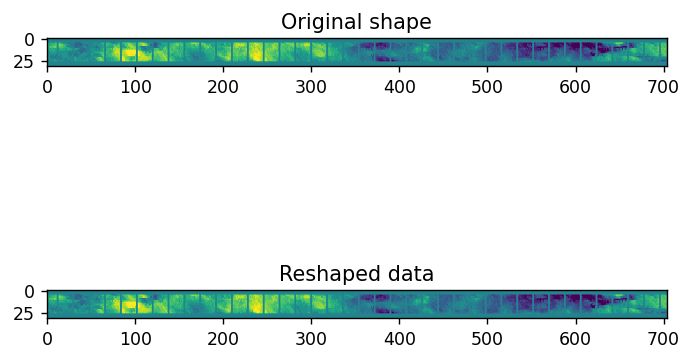

In [8]:
fig, ax = plt.subplots(2, 1, dpi=125)

ax[0].imshow(x_chunk[0,:,:].T,
             vmin=7,
             vmax=12)

ax[1].imshow(x_out[0,:,:].T,
             vmin=7,
             vmax=12)

ax[0].set_title("Original shape")
ax[1].set_title("Reshaped data")

plt.show()

In [9]:
x_out.shape

(5, 704, 32)

In [10]:
y_out.shape

(5, 704, 32)

In [11]:
n_chan

5

In [12]:
nan_replacement_vec.shape

(5,)

In [13]:
x_out

array([[[  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471],
        [  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471],
        [  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471],
        ...,
        [  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471],
        [  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471],
        [  9.25163471,   9.25163471,   9.25163471, ...,   9.25163471,
           9.25163471,   9.25163471]],

       [[  0.4404083 ,   0.4404083 ,   0.4404083 , ...,   0.4404083 ,
           0.4404083 ,   0.4404083 ],
        [  0.4404083 ,   0.4404083 ,   0.4404083 , ...,   0.4404083 ,
           0.4404083 ,   0.4404083 ],
        [  0.4404083 ,   0.4404083 ,   0.4404083 , ...,   0.4404083 ,
           0.4404083 ,   0.4404083 ],
        ...,
